In [1]:
#Data analysis
import pandas as pd
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#Modeling
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
# from sklearn_crfsuite import CRF, scorers, metrics
# import sklearn_crfsuite
# from sklearn_crfsuite import scorers
# from sklearn_crfsuite import metrics
# from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import scipy.stats
import eli5

# data

In [2]:
df = pd.read_csv('kg_ner/ner_dataset.csv', encoding="latin1")
print(df.shape)
df.head()

(1048575, 4)


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [3]:
df = df.rename(columns={"Sentence #": "sentence#"})
df.head(2)

,sentence#,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentence#  47959 non-null    object
 1   Word       1048575 non-null  object
 2   POS        1048575 non-null  object
 3   Tag        1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [5]:
data = df[df['sentence#'].notnull()]
data.shape

(47959, 4)

In [6]:
# A class to retrieve the sentences from the dataset
class getsentence(object):
    
    def __init__(self, data):
        self.n_sent = 1.0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence#").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [7]:
getter = getsentence(data)
sentences = getter.sentences
#ths is how a sentence will look like.
print(sentences[1])

[('Iranian', 'JJ', 'B-gpe')]


In [8]:
#Lets find the number of words in the dataset
words = list(set(data["Word"].values))
n_words = len(words)
print(n_words)

3798


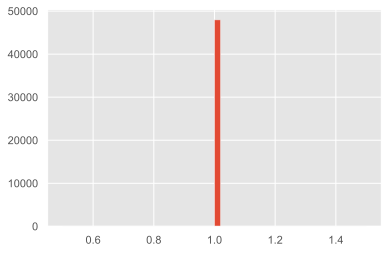

In [9]:
#Lets visualize how the sentences are distributed by their length
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [10]:
#Lets find out the longest sentence length in the dataset
maxlen = max([len(s) for s in sentences])
print ('Maximum sentence length:', maxlen)

Maximum sentence length: 1


In [11]:
#Words tagged as B-org
data.loc[data['Tag'] == 'B-org', 'Word'].head()

1372    Halliburton
1483            VOA
1624           ABAC
1683           ABAC
1801           ABAC
Name: Word, dtype: object

In [12]:
#Words tagged as I-org
data.loc[data['Tag'] == 'I-org', 'Word'].head()

Series([], Name: Word, dtype: object)

In [13]:
#Words tagged as B-per
data.loc[data['Tag'] == 'B-per', 'Word'].head()

1297        Khan
1532         Tim
1712    Harcourt
1861     Foreign
1891         Mr.
Name: Word, dtype: object

In [14]:
#Words tagged as I-per
data.loc[data['Tag'] == 'I-per', 'Word'].head()

Series([], Name: Word, dtype: object)

In [15]:
#Words tagged as B-geo
data.loc[data['Tag'] == 'B-geo', 'Word'].head()

618        Mosul
2590      Russia
3317    Pakistan
3748        U.S.
4820       Japan
Name: Word, dtype: object

In [16]:
#Words tagged as I-geo
data.loc[data['Tag'] == 'I-geo', 'Word'].head()

Series([], Name: Word, dtype: object)

In [17]:
#Words tagged as I-geo
data.loc[data['Tag'] == 'O', 'Word'].head()

0     Thousands
24     Families
54         They
68       Police
83          The
Name: Word, dtype: object

C:\Users\jhu\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


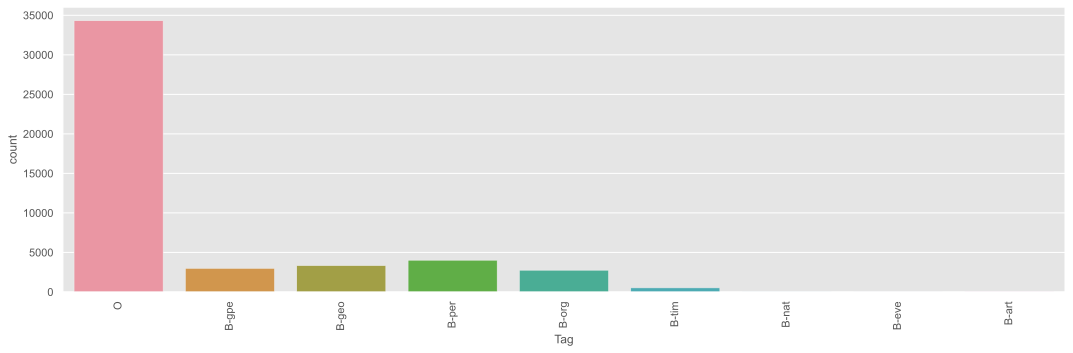

In [18]:
#Words distribution across Tags
plt.figure(figsize=(15, 5))
ax = sns.countplot('Tag', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

C:\Users\jhu\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


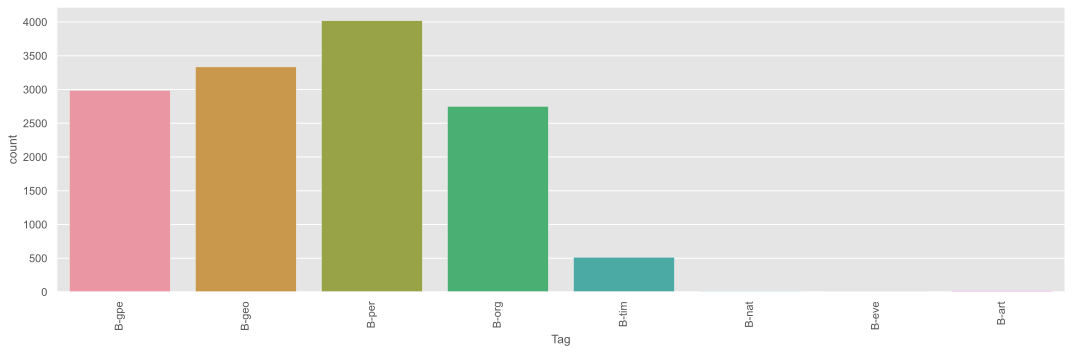

In [19]:
#Words distribution across Tags without O tag
plt.figure(figsize=(15, 5))
ax = sns.countplot('Tag', data=data.loc[data['Tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

C:\Users\jhu\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


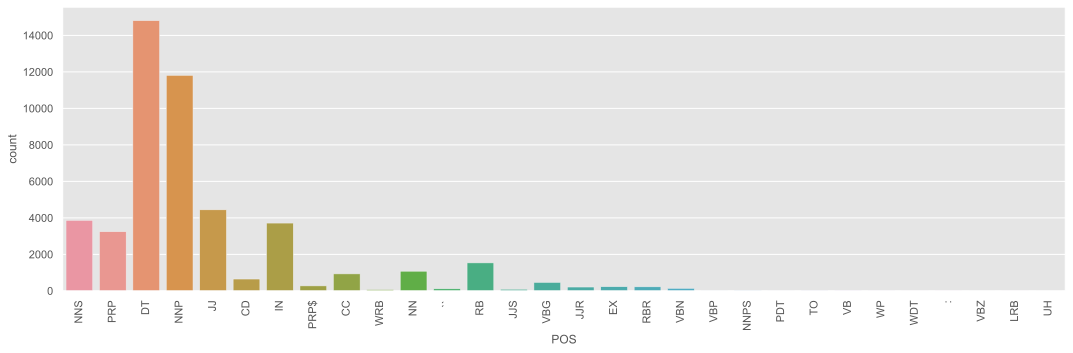

In [20]:
#Words distribution across POS
plt.figure(figsize=(15, 5))
ax = sns.countplot('POS', data=data, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

# RF

In [21]:
#Simple feature map to feed arrays into the classifier. 
def feature_map(word):
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word),
                     word.isdigit(),  word.isalpha()])

In [22]:
#We divide the dataset into train and test sets
words = [feature_map(w) for w in data["Word"].values.tolist()]
tags = data["Tag"].values.tolist()

In [23]:
#Lets see how the input array looks like
print(words[:5])

[array([1, 0, 0, 9, 0, 1]), array([1, 0, 0, 8, 0, 1]), array([1, 0, 0, 4, 0, 1]), array([1, 0, 0, 6, 0, 1]), array([1, 0, 0, 3, 0, 1])]


In [24]:
#Random Forest classifier
pred = cross_val_predict(RandomForestClassifier(n_estimators=20),X=words, y=tags, cv=5)

In [25]:
#Lets check the performance 
from sklearn.metrics import classification_report
report = classification_report(y_pred=pred, y_true=tags)
print(report)

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        18
       B-eve       0.00      0.00      0.00        10
       B-geo       0.51      0.10      0.16      3335
       B-gpe       0.00      0.00      0.00      2989
       B-nat       0.00      0.00      0.00        11
       B-org       0.79      0.20      0.32      2752
       B-per       0.99      0.39      0.56      4019
       B-tim       0.00      0.00      0.00       515
           O       0.76      1.00      0.86     34310

    accuracy                           0.76     47959
   macro avg       0.34      0.19      0.21     47959
weighted avg       0.71      0.76      0.69     47959



C:\Users\jhu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
# CRF

In [27]:
from itertools import chain

import nltk
import sklearn
import scipy.stats

import sklearn_crfsuite
from sklearn_crfsuite import scorers,CRF
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite import metrics

In [28]:
# Feature set
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

In [29]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [30]:
#Creating the train and test set
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

In [31]:
#Creating the CRF model
crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [32]:
#We predcit using the same 5 fold cross validation
pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)

C:\Users\jhu\Anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


In [33]:
#Lets evaluate the mode
report = flat_classification_report(y_pred=pred, y_true=y)
print(report)

C:\Users\jhu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

       B-art       0.67      0.11      0.19        18
       B-eve       0.00      0.00      0.00        10
       B-geo       0.74      0.86      0.80      3335
       B-gpe       0.95      0.90      0.92      2989
       B-nat       0.88      0.64      0.74        11
       B-org       0.69      0.51      0.58      2752
       B-per       0.83      0.88      0.85      4019
       B-tim       0.96      0.75      0.84       515
           O       0.98      0.99      0.98     34310

    accuracy                           0.93     47959
   macro avg       0.74      0.63      0.66     47959
weighted avg       0.93      0.93      0.93     47959



In [34]:
#Tuning the parameters manually, setting c1 = 10
crf2 = CRF(algorithm='lbfgs',
          c1=10,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [35]:
pred = cross_val_predict(estimator=crf2, X=X, y=y, cv=5)
report = flat_classification_report(y_pred=pred, y_true=y)
print(report)

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        18
       B-eve       0.00      0.00      0.00        10
       B-geo       0.73      0.75      0.74      3335
       B-gpe       0.93      0.85      0.88      2989
       B-nat       0.00      0.00      0.00        11
       B-org       0.75      0.37      0.50      2752
       B-per       0.63      0.91      0.75      4019
       B-tim       1.00      0.71      0.83       515
           O       0.98      0.98      0.98     34310

    accuracy                           0.91     47959
   macro avg       0.56      0.51      0.52     47959
weighted avg       0.91      0.91      0.91     47959

